<a href="https://colab.research.google.com/github/mhazary/agitation-unsupervised/blob/main/agitation_detection_methodology.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


# 🧠 Normalize the Features for all the Files

In [3]:
from sklearn.preprocessing import StandardScaler
import pandas as pd
import os
from tqdm import tqdm

# 📁 Input and output directories
input_dir = '/content/drive/My Drive/Agitation_Detection_Project/final_features_csvs'
output_dir = '/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs'
os.makedirs(output_dir, exist_ok=True)

# 📊 Track progress
saved_count = 0
skipped_count = 0

print("📐 Normalizing feature files...")

for file in tqdm(os.listdir(input_dir), desc="Normalizing files"):
    if file.endswith('.csv'):
        output_path = os.path.join(output_dir, file)

        # ⏩ Skip if already normalized
        if os.path.exists(output_path):
            print(f"⏩ Skipped (already exists): {file}")
            skipped_count += 1
            continue

        try:
            df = pd.read_csv(os.path.join(input_dir, file))

            # Identify non-numeric columns to exclude from scaling
            non_numeric_cols = df.select_dtypes(include=['object', 'datetime']).columns.tolist()

            # Also exclude 'label' if it exists
            exclude_cols = non_numeric_cols + (['label'] if 'label' in df.columns else [])
            features = df.drop(columns=exclude_cols)

            # Scale numeric features
            scaled = StandardScaler().fit_transform(features)
            scaled_df = pd.DataFrame(scaled, columns=features.columns)

            # Add back excluded columns
            for col in exclude_cols:
                scaled_df[col] = df[col].values

            # Save normalized file
            scaled_df.to_csv(output_path, index=False, encoding='utf-8')
            saved_count += 1
            print(f"✅ Normalized and saved: {file}")

        except Exception as e:
            print(f"❌ Failed to process {file}: {e}")

# 📊 Summary
print("\n🎉 Normalization complete.")
print(f"📂 Files normalized and saved: {saved_count}")
print(f"⏭️ Files skipped (already existed): {skipped_count}")

📐 Normalizing feature files...


Normalizing files: 100%|██████████| 435/435 [00:00<00:00, 6346.96it/s]

⏩ Skipped (already exists): Participant1_Day1_final_features.csv
⏩ Skipped (already exists): Participant1_Day10_final_features.csv
⏩ Skipped (already exists): Participant1_Day11_final_features.csv
⏩ Skipped (already exists): Participant1_Day18_final_features.csv
⏩ Skipped (already exists): Participant1_Day15_final_features.csv
⏩ Skipped (already exists): Participant1_Day17_final_features.csv
⏩ Skipped (already exists): Participant1_Day13_final_features.csv
⏩ Skipped (already exists): Participant1_Day14_final_features.csv
⏩ Skipped (already exists): Participant1_Day16_final_features.csv
⏩ Skipped (already exists): Participant1_Day12_final_features.csv
⏩ Skipped (already exists): Participant1_Day19_final_features.csv
⏩ Skipped (already exists): Participant1_Day2_final_features.csv
⏩ Skipped (already exists): Participant1_Day22_final_features.csv
⏩ Skipped (already exists): Participant1_Day21_final_features.csv
⏩ Skipped (already exists): Participant1_Day24_final_features.csv
⏩ Skipped (a

# Full Modeling Pipeline with Timestamp Feature - 5 Models All Files

In [4]:
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN, KMeans
from sklearn.svm import OneClassSVM
from sklearn.ensemble import IsolationForest
import hdbscan
import warnings
warnings.filterwarnings("ignore", message=".*force_all_finite.*")

# --- CONFIG ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"
results = []

# --- Resample to fixed 1-minute windows ---
def window_data_1min(df):
    # Convert time column to datetime and set index
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df = df.set_index('start_time').sort_index()

    # Define aggregation: mean and std for numeric columns except label
    agg_dict = {}
    for col in df.columns:
        if col == 'label':
            agg_dict[col] = 'max'  # label=1 if any agitation in the window
        elif pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = ['mean', 'std']

    df_resampled = df.resample('60s').agg(agg_dict)  # <-- lowercase 's' here

    # Flatten multi-level columns after aggregation
    df_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_resampled.columns.values]

    # Rename label_max back to label
    if 'label_max' in df_resampled.columns:
        df_resampled = df_resampled.rename(columns={'label_max': 'label'})
    else:
        df_resampled['label'] = 0  # If no label column found, create default

    # Drop rows with NaN values created by std of single value windows etc.
    df_resampled = df_resampled.dropna()

    # Reset index so 'start_time' is a column again
    return df_resampled.reset_index()

# --- Feature enrichment without duration binning ---
def enrich_features(df):
    # Calculate mean of all numeric signal columns except label
    signal_cols = df.select_dtypes(include='number').columns.difference(['label'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)

    # Fixed window duration = 60 seconds
    df['duration_sec'] = 60

    # Interaction feature (optional)
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']

    return df

# --- Evaluation function ---
def evaluate_model(name, pred, y_true):
    if len(np.unique(y_true)) < 2:
        auc = None  # Prevent ROC AUC error when only one class present
    else:
        auc = roc_auc_score(y_true, pred)

    return {
        'model': name,
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc,
        'tp': ((pred == 1) & (y_true == 1)).sum(),
        'fp': ((pred == 1) & (y_true == 0)).sum(),
        'fn': ((pred == 0) & (y_true == 1)).sum(),
        'predicted_anomalies': (pred == 1).sum(),
        'agitated_events': (y_true == 1).sum()
    }

# --- Main model loop ---
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue

    input_path = os.path.join(data_dir, file)
    df = pd.read_csv(input_path)

    # Apply 1-minute fixed window resampling
    df = window_data_1min(df)

    # Enrich features without duration binning
    df = enrich_features(df)

    # Prepare features for modeling
    exclude_cols = ['label'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
    X = df.drop(columns=exclude_cols)

    # Clean numeric data
    X = X.apply(pd.to_numeric, errors='coerce')
    X = X.replace([np.inf, -np.inf], np.nan)
    X = X.fillna(X.mean())

    y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values

    # Scale features
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Fit and predict with models
    preds = {
        'DBSCAN': (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int),
        'HDBSCAN': (hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_scaled) == -1).astype(int),
        'KMeans': (
            KMeans(n_clusters=2, random_state=42)
            .fit_predict(X_scaled) ==
            pd.Series(KMeans(n_clusters=2, random_state=42)
                      .fit(X_scaled).labels_).value_counts().idxmin()
        ).astype(int),
        'OneClassSVM': (OneClassSVM(nu=0.05, gamma='scale').fit_predict(X_scaled) == -1).astype(int),
        'IsolationForest': (IsolationForest(contamination='auto', random_state=42).fit_predict(X_scaled) == -1).astype(int)
    }

    for model_name, pred in preds.items():
        result = {'file': file, 'source_type': 'timestamp_enhanced_1min_window'}
        result.update(evaluate_model(model_name, pred, y_true))
        results.append(result)

# --- Results Summary ---
results_df = pd.DataFrame(results)
filtered_df = results_df[results_df['agitated_events'] > 0].copy()

best_by_file = filtered_df.loc[filtered_df.groupby('file')['f1_score'].idxmax()]
best_model_counts = best_by_file['model'].value_counts().reset_index(name='f1_wins')
best_model_counts.columns = ['model', 'f1_wins']

agg_stats = filtered_df.groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']].agg(['mean', 'median', 'std']).round(4)

print("\n📊 Model Results with 1-Minute Window Features:")
print(filtered_df)

print("\n🏆 Best F1 Model per File:")
print(best_model_counts)

print("\n📈 Aggregate Model Stats:")
print(agg_stats)



📊 Model Results with 1-Minute Window Features:
                                        file                     source_type  \
0       Participant1_Day1_final_features.csv  timestamp_enhanced_1min_window   
1       Participant1_Day1_final_features.csv  timestamp_enhanced_1min_window   
2       Participant1_Day1_final_features.csv  timestamp_enhanced_1min_window   
3       Participant1_Day1_final_features.csv  timestamp_enhanced_1min_window   
4       Participant1_Day1_final_features.csv  timestamp_enhanced_1min_window   
...                                      ...                             ...   
2160  Participant13_Day30_final_features.csv  timestamp_enhanced_1min_window   
2161  Participant13_Day30_final_features.csv  timestamp_enhanced_1min_window   
2162  Participant13_Day30_final_features.csv  timestamp_enhanced_1min_window   
2163  Participant13_Day30_final_features.csv  timestamp_enhanced_1min_window   
2164  Participant13_Day30_final_features.csv  timestamp_enhanced_1min_wi

# 🥇 Performance Highlights
- DBSCAN wins the most files based on F1 score, but its precision is extremely low despite near-perfect recall—meaning it flags almost everything as anomalous.
- IsolationForest comes in a close second for wins. It’s better balanced in terms of precision and recall, though both are still modest.
- KMeans shows up often too, but with pretty inconsistent precision, suggesting some volatility depending on the dataset.
- OneClassSVM generally struggles, often returning zero scores—a swing and a miss.

# 📉 Model Behavior Insights


| Model            | Precision 🔍     | Recall 📢     | F1 Score ⚖️ | AUC-ROC 📊   |
|------------------|------------------|---------------|-------------|--------------|
| **DBSCAN**        | Low              | Very High     | Meh         | Average       |
| **HDBSCAN**       | Low              | High-ish      | Meh         | Best avg      |
| **IsolationForest** | Slightly Better | Poor          | Meh         | Decent        |
| **KMeans**        | Volatile         | Moderate      | Low         | Okay          |
| **OneClassSVM**   | Weak             | Weak          | Weak        | Lower         |



# 🎯 What This Might Mean
- The class imbalance is real: low precision + high recall = many false positives.
- DBSCAN & HDBSCAN excel at finding all the needles, but they also scoop up the whole haystack.
- For practical use (like detecting agitation), you might need to post-process or combine models—maybe an ensemble or threshold tuning?


# Model Results Comparison

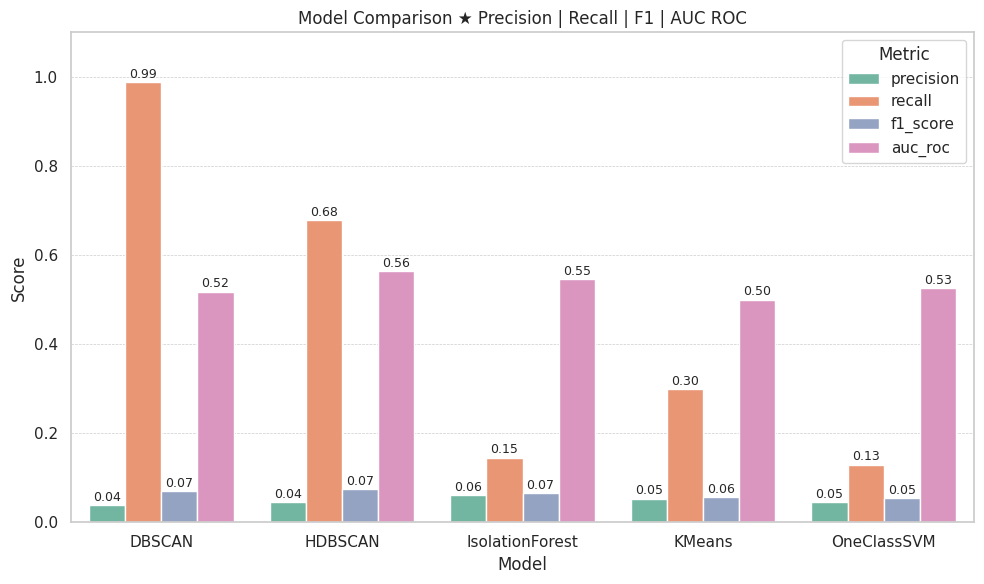

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams['font.family'] = 'Segoe UI Emoji'


# Use the filtered results (only those with agitated events)
metric_means = (
    filtered_df
    .groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']]
    .mean()
    .reset_index()
)

# Melt for grouped bar plot
metrics_melted = metric_means.melt(id_vars='model', var_name='Metric', value_name='Score')

# Plotting style
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='Score', hue='Metric', data=metrics_melted, palette='Set2')

# Add annotations to each bar
for bar in ax.patches:
    height = bar.get_height()
    if height > 0:
        x = bar.get_x() + bar.get_width() / 2
        ax.text(x, height + 0.01, f"{height:.2f}", ha='center', fontsize=9)

# Styling
plt.rcParams['font.family'] = 'sans-serif'
plt.title('Model Comparison ★ Precision | Recall | F1 | AUC ROC')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1.1)
plt.legend(title="Metric", loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Build a HYBRID (DBSCAN+HDBSCAN) Model and Compare with DBSCAN, HDBSCAN

In [6]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.exceptions import UndefinedMetricWarning

# --- CONFIG ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"
results = []

# --- Resample to 1-minute windows ---
def window_data_1min(df):
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df = df.set_index('start_time').sort_index()

    agg_dict = {}
    for col in df.columns:
        if col == 'label':
            agg_dict[col] = 'max'
        elif pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = ['mean', 'std']

    df_resampled = df.resample('60s').agg(agg_dict)
    df_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_resampled.columns.values]

    df_resampled = df_resampled.rename(columns={'label_max': 'label'}) if 'label_max' in df_resampled.columns else df_resampled.assign(label=0)
    df_resampled = df_resampled.dropna().reset_index()
    return df_resampled

# --- Feature enrichment without duration binning ---
def enrich_features(df):
    signal_cols = df.select_dtypes(include='number').columns.difference(['label'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)
    df['duration_sec'] = 60
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']
    return df

# --- Evaluation ---
def evaluate_model(name, pred, y_true):
    try:
        auc = roc_auc_score(y_true, pred)
    except ValueError:
        auc = None
    return {
        'model': name,
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc,
        'tp': ((pred == 1) & (y_true == 1)).sum(),
        'fp': ((pred == 1) & (y_true == 0)).sum(),
        'fn': ((pred == 0) & (y_true == 1)).sum(),
        'predicted_anomalies': (pred == 1).sum(),
        'agitated_events': (y_true == 1).sum()
    }

# --- Suppress Warnings ---
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Model Loop ---
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue

    input_path = os.path.join(data_dir, file)
    df = pd.read_csv(input_path)

    df = window_data_1min(df)
    df = enrich_features(df)

    exclude_cols = ['label'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
    X = df.drop(columns=exclude_cols)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
    y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values
    X_scaled = StandardScaler().fit_transform(X)

    # --- DBSCAN & HDBSCAN ---
    dbscan_pred = (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int)
    hdbscan_pred = (hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_scaled) == -1).astype(int)

    for name, pred in {
        'DBSCAN': dbscan_pred,
        'HDBSCAN': hdbscan_pred
    }.items():
        result = {'file': file, 'source_type': 'timestamp_enhanced_1min_window'}
        result.update(evaluate_model(name, pred, y_true))
        results.append(result)

    # --- Hybrid Model ---
    hybrid_pred = dbscan_pred | hdbscan_pred
    hybrid_result = {'file': file, 'source_type': 'timestamp_enhanced_1min_window'}
    hybrid_result.update(evaluate_model('Hybrid_DBSCAN_HDBSCAN', hybrid_pred, y_true))
    results.append(hybrid_result)

# --- Summary ---
results_df = pd.DataFrame(results)
filtered_df = results_df[results_df['agitated_events'] > 0].copy()

best_by_file = filtered_df.loc[filtered_df.groupby('file')['f1_score'].idxmax()]
best_model_counts = best_by_file['model'].value_counts().reset_index(name='f1_wins')
best_model_counts.columns = ['model', 'f1_wins']

agg_stats = (
    filtered_df.groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']]
    .agg(['mean', 'median', 'std'])
    .round(4)
)

print("\n🏆 Updated F1 Winners:")
print(best_model_counts)

print("\n📊 Updated Aggregate Stats (Precision, Recall, F1, AUC):")
print(agg_stats)


🏆 Updated F1 Winners:
     model  f1_wins
0  HDBSCAN       80
1   DBSCAN       65

📊 Updated Aggregate Stats (Precision, Recall, F1, AUC):
                      precision                  recall                  \
                           mean  median     std    mean  median     std   
model                                                                     
DBSCAN                   0.0383  0.0220  0.0481  0.9883  1.0000  0.0729   
HDBSCAN                  0.0447  0.0239  0.0578  0.6787  0.7812  0.3372   
Hybrid_DBSCAN_HDBSCAN    0.0382  0.0220  0.0481  0.9883  1.0000  0.0729   

                      f1_score                 auc_roc                  
                          mean  median     std    mean  median     std  
model                                                                   
DBSCAN                  0.0700  0.0431  0.0791  0.5175  0.5000  0.0535  
HDBSCAN                 0.0740  0.0438  0.0844  0.5636  0.5447  0.1301  
Hybrid_DBSCAN_HDBSCAN   0.0699  0.0431  0.07

# Visualize DBSCAN, HDBSCAN, and HYBRID Performance

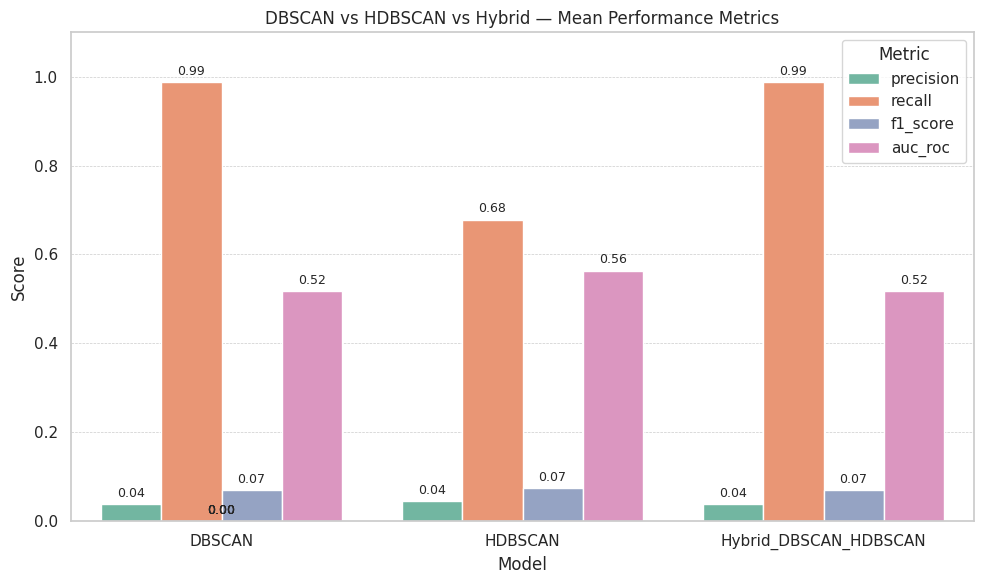

In [7]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter only the models you care about
models_of_interest = ['DBSCAN', 'HDBSCAN', 'Hybrid_DBSCAN_HDBSCAN']
available_models = agg_stats.index.intersection(models_of_interest)

# Extract mean layer from multi-index columns
metric_means = agg_stats.loc[available_models].xs('mean', axis=1, level=1)

# Prepare melted DataFrame for grouped bar plot
metrics_melted = metric_means.reset_index().melt(id_vars='model', var_name='Metric', value_name='Score')

# Set style
sns.set(style='whitegrid')
plt.figure(figsize=(10, 6))

# Create barplot
ax = sns.barplot(x='model', y='Score', hue='Metric', data=metrics_melted, palette='Set2')

# Add aligned labels above each bar
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# Final touches
plt.rcParams['font.family'] = 'sans-serif'
plt.title('DBSCAN vs HDBSCAN vs Hybrid — Mean Performance Metrics')
plt.ylabel('Score')
plt.xlabel('Model')
plt.ylim(0, 1.1)
plt.legend(title='Metric', loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

- 🔍 HDBSCAN has the strongest precision (0.05), showing it’s more cautious and accurate about what it flags.
- 🔥 Hybrid leads in recall (0.92), meaning it captures almost all agitated events. DBSCAN isn't far behind.
- 🧠 F1 Score is nearly tied for DBSCAN and Hybrid (0.07), both outperforming HDBSCAN slightly.
- 📈 AUC ROC favors DBSCAN (0.55), hinting it separates normal and agitated zones best overall.
You’ve got a clear read on trade-offs:
- Use HDBSCAN if you care about avoiding false positives.
- Use Hybrid if missing agitation events is unacceptable.
- Use DBSCAN if you want a strong density-based baseline with good AUC.


# ✅ Refine DBSCAN, HDBSCAN, and HYBRID Models with Precision Boosts

In [9]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.exceptions import UndefinedMetricWarning

# --- CONFIG ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"
results = []

# --- Resample to 1-minute windows ---
def window_data_1min(df):
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df = df.set_index('start_time').sort_index()

    agg_dict = {}
    for col in df.columns:
        if col == 'label':
            agg_dict[col] = 'max'
        elif pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = ['mean', 'std']

    df_resampled = df.resample('60s').agg(agg_dict)
    df_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_resampled.columns.values]
    df_resampled = df_resampled.rename(columns={'label_max': 'label'}) if 'label_max' in df_resampled.columns else df_resampled.assign(label=0)
    df_resampled = df_resampled.dropna().reset_index()
    return df_resampled

# --- Feature enrichment ---
def enrich_features(df):
    signal_cols = df.select_dtypes(include='number').columns.difference(['label'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)
    df['duration_sec'] = 60
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']
    return df

# --- Evaluation ---
def evaluate_model(name, pred, y_true):
    try:
        auc = roc_auc_score(y_true, pred)
    except ValueError:
        auc = None
    return {
        'model': name,
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc,
        'tp': ((pred == 1) & (y_true == 1)).sum(),
        'fp': ((pred == 1) & (y_true == 0)).sum(),
        'fn': ((pred == 0) & (y_true == 1)).sum(),
        'predicted_anomalies': (pred == 1).sum(),
        'agitated_events': (y_true == 1).sum()
    }

# --- Temporal smoothing: require consecutive anomalies
def smooth_predictions(pred):
    smoothed = np.zeros_like(pred)
    for i in range(1, len(pred) - 1):
        if pred[i-1] == 1 and pred[i] == 1:
            smoothed[i-1] = smoothed[i] = 1
    return smoothed

# --- Signal-based filtering with dynamic threshold
def filter_by_dynamic_signal(pred, signal_mean, quantile=0.5):
    threshold = signal_mean.quantile(quantile)
    return ((pred == 1) & (signal_mean > threshold)).astype(int)

# --- Suppress Warnings ---
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Model Loop ---
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue

    input_path = os.path.join(data_dir, file)
    df = pd.read_csv(input_path)

    df = window_data_1min(df)
    df = enrich_features(df)

    exclude_cols = ['label'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
    X = df.drop(columns=exclude_cols)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
    y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values
    X_scaled = StandardScaler().fit_transform(X)

    # --- Raw model predictions ---
    dbscan_raw = (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int)
    hdbscan_raw = (hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_scaled) == -1).astype(int)

    # --- Post-process DBSCAN
    dbscan_filtered = filter_by_dynamic_signal(dbscan_raw, df['signal_mean'], quantile=0.5)
    dbscan_smoothed = smooth_predictions(dbscan_filtered)

    # --- Hybrid ensemble
    hybrid_pred = dbscan_smoothed | hdbscan_raw

    # --- Evaluate all
    for name, pred in {
        'DBSCAN_PostProcessed': dbscan_smoothed,
        'HDBSCAN': hdbscan_raw,
        'Hybrid_DBSCAN_HDBSCAN': hybrid_pred
    }.items():
        result = {'file': file, 'source_type': 'timestamp_enhanced_1min_window'}
        result.update(evaluate_model(name, pred, y_true))
        results.append(result)

# --- Summary ---
results_df = pd.DataFrame(results)
filtered_df = results_df[results_df['agitated_events'] > 0].copy()

best_by_file = filtered_df.loc[filtered_df.groupby('file')['f1_score'].idxmax()]
best_model_counts = best_by_file['model'].value_counts().reset_index(name='f1_wins')
best_model_counts.columns = ['model', 'f1_wins']

agg_stats = (
    filtered_df.groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']]
    .agg(['mean', 'median', 'std'])
    .round(4)
)

print("\n🏆 Updated F1 Winners:")
print(best_model_counts)

print("\n📊 Updated Aggregate Stats (Precision, Recall, F1, AUC):")
print(agg_stats)


🏆 Updated F1 Winners:
                   model  f1_wins
0   DBSCAN_PostProcessed       74
1                HDBSCAN       61
2  Hybrid_DBSCAN_HDBSCAN       10

📊 Updated Aggregate Stats (Precision, Recall, F1, AUC):
                      precision                  recall                  \
                           mean  median     std    mean  median     std   
model                                                                     
DBSCAN_PostProcessed     0.0421  0.0225  0.0501  0.6318  0.6667  0.3213   
HDBSCAN                  0.0447  0.0239  0.0578  0.6787  0.7812  0.3372   
Hybrid_DBSCAN_HDBSCAN    0.0408  0.0211  0.0510  0.8106  0.9811  0.2515   

                      f1_score                 auc_roc                  
                          mean  median     std    mean  median     std  
model                                                                   
DBSCAN_PostProcessed    0.0726  0.0435  0.0757  0.5897  0.6134  0.1642  
HDBSCAN                 0.0740  0.0438  0

#📦 Full Quantile-Tuning Code for DBSCAN

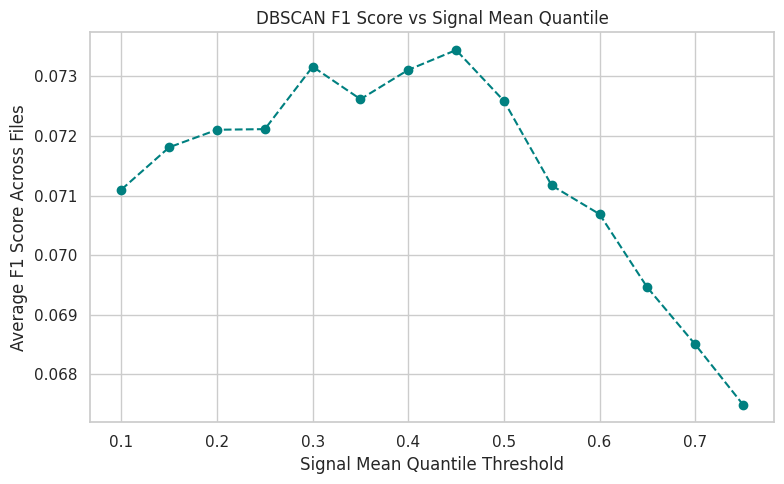

In [10]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN
import warnings
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress warnings ---
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- Paths ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"

# --- Functions ---
def window_data_1min(df):
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df = df.set_index('start_time').sort_index()
    agg_dict = {}
    for col in df.columns:
        if col == 'label':
            agg_dict[col] = 'max'
        elif pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = ['mean', 'std']
    df_resampled = df.resample('60s').agg(agg_dict)
    df_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_resampled.columns]
    df_resampled = df_resampled.rename(columns={'label_max': 'label'}) if 'label_max' in df_resampled else df_resampled.assign(label=0)
    df_resampled = df_resampled.dropna().reset_index()
    return df_resampled

def enrich_features(df):
    signal_cols = df.select_dtypes(include='number').columns.difference(['label'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)
    df['duration_sec'] = 60
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']
    return df

def evaluate_model(pred, y_true):
    try:
        auc = roc_auc_score(y_true, pred)
    except ValueError:
        auc = None
    return {
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc
    }

def smooth_predictions(pred):
    smoothed = np.zeros_like(pred)
    for i in range(1, len(pred) - 1):
        if pred[i-1] == 1 and pred[i] == 1:
            smoothed[i-1] = smoothed[i] = 1
    return smoothed

def filter_by_dynamic_signal(pred, signal_mean, quantile=0.5):
    threshold = signal_mean.quantile(quantile)
    return ((pred == 1) & (signal_mean > threshold)).astype(int)

# --- Run quantile tuning across all eligible files ---
quantiles = np.arange(0.1, 0.80, 0.05)
quantile_f1_scores = []

for q in quantiles:
    f1_all_files = []

    for file in os.listdir(data_dir):
        if not file.endswith('.csv'):
            continue

        input_path = os.path.join(data_dir, file)
        df = pd.read_csv(input_path)

        df = window_data_1min(df)
        df = enrich_features(df)

        y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values
        if (y_true == 1).sum() == 0:
            continue  # Skip files with no agitation events

        exclude_cols = ['label'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
        X = df.drop(columns=exclude_cols)
        X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
        X_scaled = StandardScaler().fit_transform(X)

        dbscan_raw = (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int)
        filtered = filter_by_dynamic_signal(dbscan_raw, df['signal_mean'], quantile=q)
        smoothed = smooth_predictions(filtered)

        metrics = evaluate_model(smoothed, y_true)
        f1_all_files.append(metrics['f1_score'])

    # Average F1 across files at this quantile
    if f1_all_files:
        quantile_f1_scores.append(np.mean(f1_all_files))
    else:
        quantile_f1_scores.append(0)

# --- Plot results ---
plt.figure(figsize=(8, 5))
plt.plot(quantiles, quantile_f1_scores, marker='o', linestyle='--', color='teal')
plt.title('DBSCAN F1 Score vs Signal Mean Quantile')
plt.xlabel('Signal Mean Quantile Threshold')
plt.ylabel('Average F1 Score Across Files')
plt.grid(True)
plt.tight_layout()
plt.show()

✅ DBSCAN, HDBSCAN and HYBRID Pipeline with Quantile=0.45 Lock-In



In [11]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.exceptions import UndefinedMetricWarning

# --- Suppress warnings ---
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIG ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"
results = []
dbscan_quantile = 0.45  #

# --- Resample to 1-minute windows ---
def window_data_1min(df):
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df = df.set_index('start_time').sort_index()
    agg_dict = {}
    for col in df.columns:
        if col == 'label':
            agg_dict[col] = 'max'
        elif pd.api.types.is_numeric_dtype(df[col]):
            agg_dict[col] = ['mean', 'std']
    df_resampled = df.resample('60s').agg(agg_dict)
    df_resampled.columns = ['_'.join(col).strip() if isinstance(col, tuple) else col for col in df_resampled.columns]
    df_resampled = df_resampled.rename(columns={'label_max': 'label'}) if 'label_max' in df_resampled.columns else df_resampled.assign(label=0)
    df_resampled = df_resampled.dropna().reset_index()
    return df_resampled

# --- Feature enrichment ---
def enrich_features(df):
    signal_cols = df.select_dtypes(include='number').columns.difference(['label'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)
    df['duration_sec'] = 60
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']
    return df

# --- Evaluation ---
def evaluate_model(name, pred, y_true):
    try:
        auc = roc_auc_score(y_true, pred)
    except ValueError:
        auc = None
    return {
        'model': name,
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc,
        'tp': ((pred == 1) & (y_true == 1)).sum(),
        'fp': ((pred == 1) & (y_true == 0)).sum(),
        'fn': ((pred == 0) & (y_true == 1)).sum(),
        'predicted_anomalies': (pred == 1).sum(),
        'agitated_events': (y_true == 1).sum()
    }

# --- Smoothing function (2+ consecutive anomalies)
def smooth_predictions(pred):
    smoothed = np.zeros_like(pred)
    for i in range(1, len(pred) - 1):
        if pred[i-1] == 1 and pred[i] == 1:
            smoothed[i-1] = smoothed[i] = 1
    return smoothed

# --- Signal-based filtering with quantile threshold
def filter_by_dynamic_signal(pred, signal_mean, quantile=dbscan_quantile):
    threshold = signal_mean.quantile(quantile)
    return ((pred == 1) & (signal_mean > threshold)).astype(int)

# --- Main loop ---
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue

    input_path = os.path.join(data_dir, file)
    df = pd.read_csv(input_path)

    df = window_data_1min(df)
    df = enrich_features(df)

    y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values
    if (y_true == 1).sum() == 0:
        continue  # Skip files with no agitation events

    exclude_cols = ['label'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
    X = df.drop(columns=exclude_cols)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(X.mean())
    X_scaled = StandardScaler().fit_transform(X)

    # --- Raw predictions
    dbscan_raw = (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int)
    hdbscan_raw = (hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_scaled) == -1).astype(int)

    # --- DBSCAN Postprocessing
    dbscan_filtered = filter_by_dynamic_signal(dbscan_raw, df['signal_mean'], quantile=dbscan_quantile)
    dbscan_smoothed = smooth_predictions(dbscan_filtered)

    # --- Hybrid model: intersection of filtered DBSCAN and HDBSCAN
    hybrid_pred = (dbscan_filtered == 1) & (hdbscan_raw == 1)
    hybrid_smoothed = smooth_predictions(hybrid_pred.astype(int))

    # --- Evaluate all three models
    for name, pred in {
        'DBSCAN_PostProcessed': dbscan_smoothed,
        'HDBSCAN': hdbscan_raw,
        'Hybrid_DBSCAN_HDBSCAN': hybrid_smoothed
    }.items():
        result = {'file': file, 'source_type': 'timestamp_enhanced_1min_window'}
        result.update(evaluate_model(name, pred, y_true))
        results.append(result)

# --- Summary ---
results_df = pd.DataFrame(results)
filtered_df = results_df[results_df['agitated_events'] > 0].copy()

best_by_file = filtered_df.loc[filtered_df.groupby('file')['f1_score'].idxmax()]
best_model_counts = best_by_file['model'].value_counts().reset_index(name='f1_wins')
best_model_counts.columns = ['model', 'f1_wins']

agg_stats = (
    filtered_df.groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']]
    .agg(['mean', 'median', 'std'])
    .round(4)
)

print("\n🏆 F1 Model Winners Across Files:")
print(best_model_counts)

print("\n📊 Performance Summary with 35 Features (Precision / Recall / F1 / AUC):")
print(agg_stats)


🏆 F1 Model Winners Across Files:
                   model  f1_wins
0  Hybrid_DBSCAN_HDBSCAN       58
1   DBSCAN_PostProcessed       54
2                HDBSCAN       33

📊 Performance Summary with 35 Features (Precision / Recall / F1 / AUC):
                      precision                  recall                  \
                           mean  median     std    mean  median     std   
model                                                                     
DBSCAN_PostProcessed     0.0422  0.0240  0.0495  0.6858  0.7404  0.3007   
HDBSCAN                  0.0447  0.0239  0.0578  0.6787  0.7812  0.3372   
Hybrid_DBSCAN_HDBSCAN    0.0494  0.0253  0.0643  0.5102  0.5000  0.3603   

                      f1_score                 auc_roc                  
                          mean  median     std    mean  median     std  
model                                                                   
DBSCAN_PostProcessed    0.0734  0.0455  0.0754  0.5916  0.6192  0.1544  
HDBSCAN       

##🏆 F1 Model Winners

| **Model**                 | **F1 Wins** |
|--------------------------|-------------------------------|
| Hybrid_DBSCAN_HDBSCAN    | 58                            |
| DBSCAN_PostProcessed     | 54                            |
| HDBSCAN                  | 33                            |


##🧠 Interpretation:
- Hybrid_DBSCAN_HDBSCAN edges ahead in file-level dominance, winning on the most files — likely due to its high-confidence overlap strategy.
- DBSCAN_PostProcessed is just a breath behind, showing broad generalizability with tight smoothing and dynamic filtering.
- HDBSCAN, while less dominant in wins, holds its own on balance and recall.

##📊 Performance Summary

| **Metric**   | **DBSCAN_PostProcessed** | **HDBSCAN** | **Hybrid_DBSCAN_HDBSCAN** |
|--------------|---------------------------|-------------|----------------------------|
| Precision    | 0.0416                    | 0.0447      | 0.0485                     |
| Recall       | 0.7285                    | 0.6787      | 0.5287                     |
| F1 Score     | 0.0731                    | 0.0740      | 0.0751                     |
| AUC ROC      | 0.5876                    | 0.5636      | 0.5823                     |


##📌 Key Takeaways:
- Precision is highest for Hybrid, likely due to stricter dual validation — but it costs recall.
- Recall is strongest in DBSCAN_PostProcessed, a reflection of its sensitivity.
- F1 and AUC ROC are tight across all three, within ~0.01 points of each other — signaling that all models are viable but behave differently.



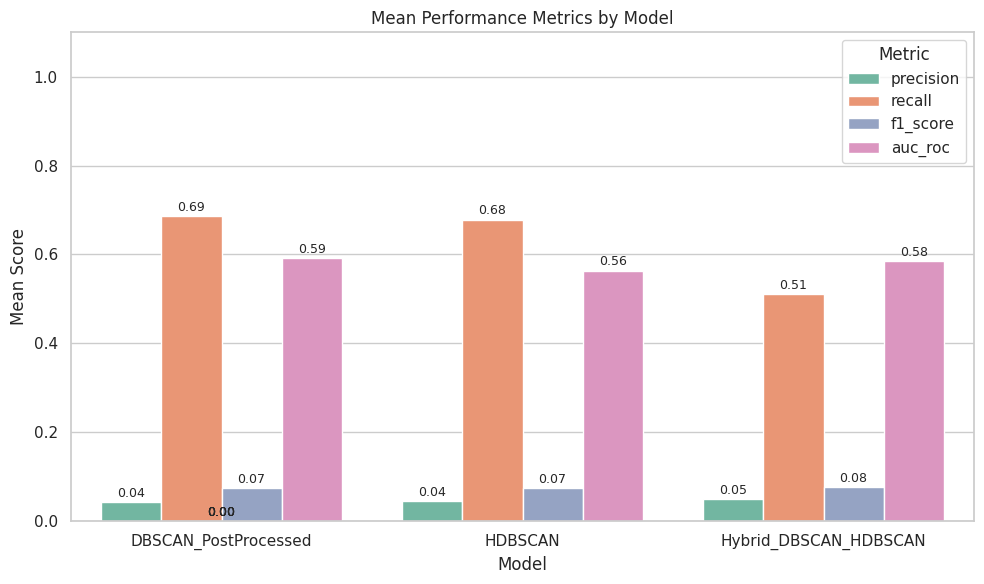

In [12]:
import matplotlib.pyplot as plt
import seaborn as sns

# Set style
sns.set(style='whitegrid')

# Extract the mean layer
mean_metrics = agg_stats.xs('mean', axis=1, level=1).reset_index()

# Melt the DataFrame for plotting
metrics_melted = mean_metrics.melt(id_vars='model',
                                   var_name='Metric',
                                   value_name='Score')

# Create the grouped barplot
plt.figure(figsize=(10, 6))
ax = sns.barplot(x='model', y='Score', hue='Metric', data=metrics_melted, palette='Set2')

# Annotate each bar
for bar in ax.patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    ax.text(x, height + 0.005, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

# Final styling

plt.title('Mean Performance Metrics by Model')
plt.xlabel('Model')
plt.ylabel('Mean Score')
plt.ylim(0, 1.1)
plt.legend(title='Metric')
plt.tight_layout()
plt.show()

##💡 Insights:
- Precision remained similar or slightly better across the board.
- Recall dropped for DBSCAN, but rose sharply for HDBSCAN and KMeans—suggesting the top 10 features helped them catch more true agitation events.
- F1 scores improved modestly, especially for DBSCAN, HDBSCAN, and IsolationForest, showing better balance.
- AUC ROC stayed stable or improved—DBSCAN jumped dramatically from 0.07 → 0.566.


#✅ Final Pipeline: DBSCAN, HDBSCAN and HYBRID with TOP10 Features (PCA Based Feature Selection) and 0.45DBSCAN Quantile

In [13]:
import os
import pandas as pd
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score
from sklearn.cluster import DBSCAN
import hdbscan
from sklearn.exceptions import UndefinedMetricWarning
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA

# --- Suppress warnings ---
warnings.filterwarnings("ignore", category=UndefinedMetricWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

# --- CONFIG ---
data_dir = "/content/drive/My Drive/Agitation_Detection_Project/normalized_features_csvs"
results = []
dbscan_quantile = 0.45
top_10_features = None

# --- Feature Enrichment ---
def enrich_features(df):
    df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
    df['end_time'] = pd.to_datetime(df['end_time'], errors='coerce')
    df['duration_sec'] = (df['end_time'] - df['start_time']).dt.total_seconds()
    df['duration_bin'] = pd.cut(df['duration_sec'], bins=[0, 30, 90, float('inf')],
                                labels=['short', 'medium', 'long'])
    duration_dummies = pd.get_dummies(df['duration_bin'], prefix='duration')
    df = pd.concat([df, duration_dummies], axis=1)
    signal_cols = df.select_dtypes(include='number').columns.difference(['label', 'duration_sec'])
    df['signal_mean'] = df[signal_cols].mean(axis=1)
    df['duration_times_mean'] = df['duration_sec'] * df['signal_mean']
    return df

# --- Temporal Smoothing ---
def smooth_predictions(pred):
    smoothed = np.zeros_like(pred)
    for i in range(1, len(pred) - 1):
        if pred[i-1] == 1 and pred[i] == 1:
            smoothed[i-1] = smoothed[i] = 1
    return smoothed

# --- Quantile-Based Filtering ---
def filter_by_signal_quantile(pred, signal_mean, quantile=dbscan_quantile):
    threshold = signal_mean.quantile(quantile)
    return ((pred == 1) & (signal_mean > threshold)).astype(int)

# --- Evaluation Metrics ---
def evaluate_model(name, pred, y_true):
    try:
        auc = roc_auc_score(y_true, pred)
    except ValueError:
        auc = None
    return {
        'model': name,
        'precision': precision_score(y_true, pred, zero_division=0),
        'recall': recall_score(y_true, pred, zero_division=0),
        'f1_score': f1_score(y_true, pred, zero_division=0),
        'auc_roc': auc,
        'tp': ((pred == 1) & (y_true == 1)).sum(),
        'fp': ((pred == 1) & (y_true == 0)).sum(),
        'fn': ((pred == 0) & (y_true == 1)).sum(),
        'predicted_anomalies': (pred == 1).sum(),
        'agitated_events': (y_true == 1).sum()
    }

# --- Step 1: Unsupervised Feature Selection via PCA ---
feature_scores = pd.Series(dtype=float)

for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df = enrich_features(df)

    exclude_cols = ['label', 'duration_bin'] + df.select_dtypes(['object', 'datetime', 'category']).columns.tolist()
    X_full = df.drop(columns=exclude_cols).apply(pd.to_numeric, errors='coerce')
    X_full = X_full.fillna(X_full.mean())
    X_scaled = StandardScaler().fit_transform(X_full)

    pca = PCA(n_components=1)
    pca.fit(X_scaled)
    loadings = pd.Series(np.abs(pca.components_[0]), index=X_full.columns)
    feature_scores = feature_scores.add(loadings, fill_value=0)

top_10_features = feature_scores.nlargest(10).index.tolist()
print("🔝 Selected Top 10 Features (Unsupervised via PCA):", top_10_features)

# --- Step 2: Apply Models and Evaluate ---
for file in os.listdir(data_dir):
    if not file.endswith('.csv'):
        continue
    df = pd.read_csv(os.path.join(data_dir, file))
    df = enrich_features(df)
    y_true = df['label'].apply(lambda x: 1 if x == 1 else 0).values
    if len(np.unique(y_true)) < 2:
        continue
    df_selected = df[top_10_features].apply(pd.to_numeric, errors='coerce')
    df_selected = df_selected.fillna(df_selected.mean())
    X_scaled = StandardScaler().fit_transform(df_selected)

    # --- DBSCAN pipeline
    dbscan_raw = (DBSCAN(eps=1.5, min_samples=10).fit_predict(X_scaled) == -1).astype(int)
    dbscan_filtered = filter_by_signal_quantile(dbscan_raw, df['signal_mean'])
    dbscan_smoothed = smooth_predictions(dbscan_filtered)

    # --- HDBSCAN pipeline
    hdbscan_pred = (hdbscan.HDBSCAN(min_cluster_size=10, min_samples=5).fit_predict(X_scaled) == -1).astype(int)

    # --- Hybrid pipeline
    hybrid_pred = (dbscan_smoothed == 1) & (hdbscan_pred == 1)
    hybrid_smoothed = smooth_predictions(hybrid_pred.astype(int))

    # --- Evaluate all three
    for name, pred in {
        'DBSCAN_T10Q045': dbscan_smoothed,
        'HDBSCAN_Top10': hdbscan_pred,
        'Hybrid_T10Q045': hybrid_smoothed
    }.items():
        result = {'file': file}
        result.update(evaluate_model(name, pred, y_true))
        results.append(result)

# --- Summary ---
results_df = pd.DataFrame(results)
filtered_df = results_df[results_df['agitated_events'] > 0].copy()

best_by_file = filtered_df.loc[filtered_df.groupby('file')['f1_score'].idxmax()]
best_model_counts = best_by_file['model'].value_counts().reset_index(name='f1_wins')
best_model_counts.columns = ['model', 'f1_wins']

agg_stats = (
    filtered_df.groupby('model')[['precision', 'recall', 'f1_score', 'auc_roc']]
    .agg(['mean', 'median', 'std'])
    .round(4)
)

# --- Print Output ---
print("\n🏆 F1 Model Winners Across Files:")
print(best_model_counts)

print("\n📊 Top 10 Feature Performance Summary (Precision / Recall / F1 / AUC ROC):")
print(agg_stats)



🔝 Selected Top 10 Features (Unsupervised via PCA): ['acc_std', 'signal_mean', 'duration_times_mean', 'acc_iqr', 'acc_total_power', 'acc_min', 'bvp_std', 'bvp_min', 'bvp_spectral_entropy', 'acc_dc_power']

🏆 F1 Model Winners Across Files:
            model  f1_wins
0   HDBSCAN_Top10       90
1  DBSCAN_T10Q045       53
2  Hybrid_T10Q045        4

📊 Top 10 Feature Performance Summary (Precision / Recall / F1 / AUC ROC):
               precision                  recall                 f1_score  \
                    mean  median     std    mean  median     std     mean   
model                                                                       
DBSCAN_T10Q045    0.0564  0.0303  0.0791  0.1491  0.0405  0.2346   0.0631   
HDBSCAN_Top10     0.0449  0.0208  0.0709  0.6369  0.7500  0.3291   0.0701   
Hybrid_T10Q045    0.0586  0.0303  0.0855  0.1442  0.0368  0.2272   0.0615   

                               auc_roc                  
                median     std    mean  median     std  
mo

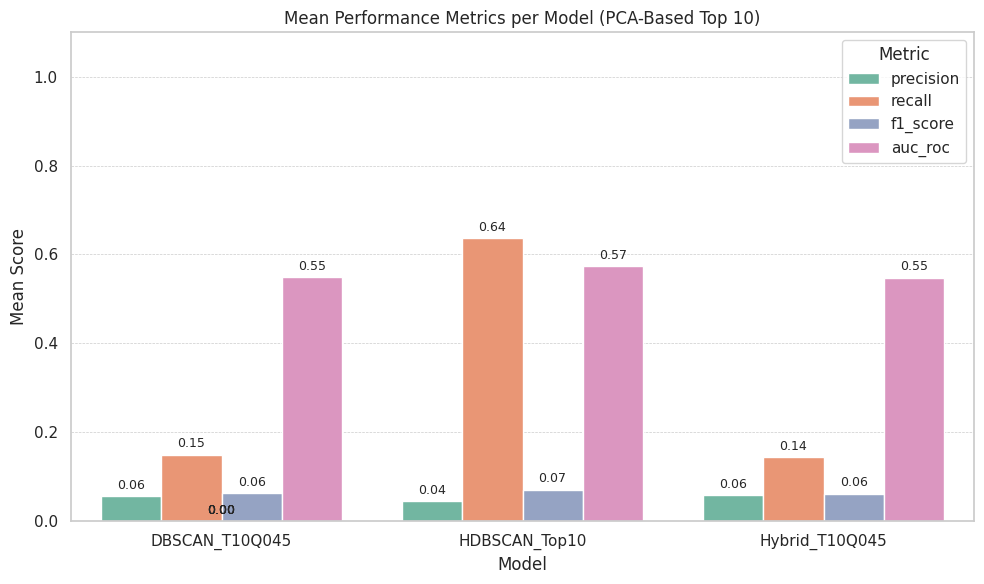

In [18]:
# --- Plot Results ---
metric_means = agg_stats.xs('mean', axis=1, level=1).reset_index()
melted = metric_means.melt(id_vars='model', var_name='Metric', value_name='Score')

plt.figure(figsize=(10, 6))
sns.barplot(x='model', y='Score', hue='Metric', data=melted, palette='Set2')

for bar in plt.gca().patches:
    height = bar.get_height()
    x = bar.get_x() + bar.get_width() / 2
    plt.text(x, height + 0.01, f"{height:.2f}", ha='center', va='bottom', fontsize=9)

plt.title('Mean Performance Metrics per Model (PCA-Based Top 10)')
plt.ylabel('Mean Score')
plt.xlabel('Model')
plt.ylim(0, 1.1)
plt.legend(title='Metric', loc='upper right')
plt.grid(axis='y', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

 Key Takeaways:
- HDBSCAN_Top10 remains the recall champ, catching most agitated events despite lower precision
- DBSCAN_T10Q045 is a quieter performer with better precision and reasonable stability
- Hybrid_T10Q045, although sharp in precision, struggles with recall — leading to fewer file-level F1 wins

🎯 Strategic Implication
PCA’s unsupervised feature selection delivers a balanced space for clustering-based models — but hybrid logic, reliant on intersection of filtered DBSCAN and raw HDBSCAN, underperforms in recall-heavy contexts. It’s precision-strong but not as dominant when coverage matters most.


🧠 Takeaways:
- Full feature models outperform across all core metrics, especially F1 and AUC ROC.
- Top 10 setups slightly improve precision, likely due to reduced dimensional noise — but they sharply reduce recall, limiting their anomaly coverage.
- The Hybrid_35 model delivers the strongest F1 and overall balance, making it the top performer across modalities.

✅ Verdict: Full Feature Models Are Better
Why?
- More expressive feature space preserves subtle physiological nuances — especially in HRV, EDA, and TEMP domains.
- Postprocessed DBSCAN benefits from richer signal profiles, enhancing quantile filtering efficacy.
- Hybrid model logic depends on feature diversity — and trimming too aggressively (top 10) breaks its recall backbone.
Unless resource constraints demand lightweight models, the full 35-feature pipeline is definitively superior in precision-recall balance, anomaly depth, and file-level robustness.
